In [1]:
import warnings
warnings.filterwarnings('ignore')

from src.data import DataLoaders
from src import utils
import pandas as pd
from src.models.ModelClasses import FireRiskModels, SmokeAlarmModels
from matplotlib import pyplot as plt
from pathlib import Path
from datetime import date, datetime
import numpy as np
#import geopandas as geo
import subprocess

from IPython.display import display, Markdown

Create report with: `jupyter nbconvert --to pdf --output withMarkdownPDF --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags=['remove_cell']  --no-input testScript.ipynb`

# Fire Models

In [2]:
# grab version of code 
#subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD'])

In [8]:
master_log_file_path = utils.DATA['logging'] / 'MasterLog.csv'



In [9]:
if master_log_file_path.exists():
    experiment_num = pd.read_csv( master_log_file_path).shape[0] + 1 
else:
     experiment_num = 1 
experiment_num

5

In [11]:

expt_path =  Path.cwd() / 'Data' /  'Logs' / f'Experiment_{experiment_num}'

In [2]:
# put all task variables here 
ACS_year = 2016
NFIRS_year_predicted =  2018
NFIRS_num_training_years  =  5
NFIRS_year_used_end = NFIRS_year_predicted -1 

In [3]:
display(Markdown('**The following columns are being kept**'))
ACS_cols_to_use =[ 'did_not_work_past_12_mo',
               'house_pct_live_alone',
               'pct_alt_heat',
               'house_yr_pct_before_1960',
               'inc_pct_poverty',
               'race_pct_black_or_amind']
print(ACS_cols_to_use)

**The following columns are being kept**

['did_not_work_past_12_mo', 'house_pct_live_alone', 'pct_alt_heat', 'house_yr_pct_before_1960', 'inc_pct_poverty', 'race_pct_black_or_amind']


In [5]:
Code_repo = subprocess.check_output(['git', 'config', '--get', 'remote.origin.url'])
Code_version =  subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD']).strip()

In [12]:
expt_log =  pd.DataFrame( {'Experiment': experiment_num ,
 'Date': datetime.now(),
 'expt_folder' : expt_path,
 'Code_Repo' :   Code_repo ,                        
 'Code_Version': Code_version ,
 'ACS_Version': '2016',
 'Level': 'block_group',
 'NFIRS_year_used_start': NFIRS_year_used_end - NFIRS_num_training_years,                                        
 'NFIRS_year_used_end': NFIRS_year_used_end ,
 'NFIRS_year_predicted': NFIRS_year_predicted,  
  'Severity_dollar_estimate' : 10000,
  'ACS_cols_used': [ACS_cols_to_use] 
} )

expt_log = expt_log.set_index('Experiment')


In [6]:
from datetime import datetime

In [ ]:
print(datetime.now())

In [ ]:
if master_log_file_path.exists():
    expt_log.to_csv ( master_log_file_path,mode ='a', header = False )
else:
    expt_log.to_csv ( master_log_file_path, header = True )
    



In [4]:
ACS =  DataLoaders.ACSData(ACS_year,'block_group')

In [5]:
NFIRS = DataLoaders.NFIRSData('block_group',ACS.tot_pop)
NFIRS_Sev = DataLoaders.NFIRSData('block_group',ACS.tot_pop,sev=True)

In [6]:


FSM =  FireRiskModels('severity')
FPM =  FireRiskModels('propensity')

## Fire Propensity Model

In [7]:
FPM.train( NFIRS = NFIRS,
          ACS= ACS,
          ACS_variables = ACS_cols_to_use,
          prediction_year = NFIRS_year_predicted,
          n_years = NFIRS_num_training_years)

Testing 2017:
Predicting 2018:


**Confusion Matrix**

[[32377  8626]
 [  442  1820]]


**ROC AUC Score** = 0.8774281530757719

**Classication Report**

              precision    recall  f1-score   support

       False       0.99      0.79      0.88     41003
        True       0.17      0.80      0.29      2262

    accuracy                           0.79     43265
   macro avg       0.58      0.80      0.58     43265
weighted avg       0.94      0.79      0.85     43265



**Feature Ranking**

1. Max (0.448675)
2. Median (0.131849)
3. race_pct_black_or_amind (0.079167)
4. house_yr_pct_before_1960 (0.070156)
5. inc_pct_poverty (0.069935)
6. house_pct_live_alone (0.068317)
7. pct_alt_heat (0.066529)
8. did_not_work_past_12_mo (0.065372)


## Fire Severity Model

In [8]:
FSM.train( NFIRS = NFIRS_Sev,
          ACS= ACS,
          ACS_variables = ACS_cols_to_use,
          prediction_year = NFIRS_year_predicted,
          n_years = NFIRS_num_training_years)

Testing 2017:
Predicting 2018:


**Confusion Matrix**

[[33155  9364]
 [  191   555]]


**ROC AUC Score** = 0.836317616593673

**Classication Report**

              precision    recall  f1-score   support

       False       0.99      0.78      0.87     42519
        True       0.06      0.74      0.10       746

    accuracy                           0.78     43265
   macro avg       0.53      0.76      0.49     43265
weighted avg       0.98      0.78      0.86     43265



**Feature Ranking**

1. Median (0.362690)
2. Max (0.163538)
3. race_pct_black_or_amind (0.086119)
4. did_not_work_past_12_mo (0.081613)
5. inc_pct_poverty (0.077854)
6. house_pct_live_alone (0.076843)
7. pct_alt_heat (0.076100)
8. house_yr_pct_before_1960 (0.075245)


In [ ]:
#ARC.data

# Smoke Alarm Models

In [9]:
ARC =  DataLoaders.ARCPData(ACS)

In [10]:
SVI =  DataLoaders.SVIData(ACS.data)
#SVI.data

In [11]:
Smoke = SmokeAlarmModels()

Training State smoke alarm stats model
Training County smoke alarm stats model
Training Tract smoke alarm stats model
Training Block_Group smoke alarm stats model
Training MultiLevel smoke alarm stats model
Training DL model


**Training Performance**

105.79741724398383
Test RMSE: 10.285787147514954
Test MAE: 7.729334616282021


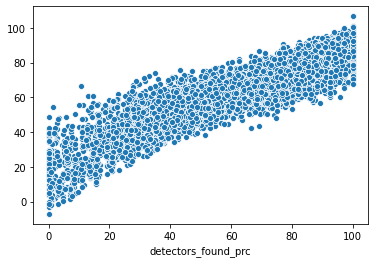

**Testing Performance**

Test RMSE: 14.931982915784534
Test MAE: 11.362082576867268


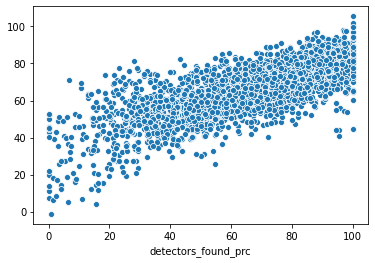

Test Correlation: (0.7416691507344358, 0.0)
Test R-squared: 0.536587473599111


**Feature Ranking**

1. RPL_THEME1 (0.214602)
2. RPL_THEME2 (0.116916)
3. RPL_THEME4 (0.112707)
4. RPL_THEME3 (0.109658)
5. Population Density (per square mile), 2010 (0.107959)
6. race_pct_black_or_amind (0.086700)
7. pct_alt_heat (0.069408)
8. house_yr_pct_before_1960 (0.063759)
9. inc_pct_poverty_x (0.048886)
10. did_not_work_past_12_mo (0.036040)
11. house_pct_live_alone (0.033364)
12. inc_pct_poverty_y (0.000000)


In [12]:
svi_use = True
smoke_prediction = Smoke.trainModels(ARC,ACS,SVI, ACS_cols_to_use,svi_use, utils.DATA['data'])

# Saving File

In [ ]:
out_path = utils.DATA['model-outputs'] / f'experiment_{experiment_num}' 
Path.mkdir(out_path, exist_ok = True)

In [13]:
out = NFIRS.fires.copy()
out.columns =  'fires_per_1K_pop_' + out.columns
cols = out.columns

In [14]:
out = ACS.data.merge(out, how = 'left', left_index = True, right_index = True)
out = out[cols]

In [15]:
# Smoke Alarm model munging 


# add number of surveys recorded at the block level
num_surveys_block = Smoke.models['Block_Group']['num_surveys'].copy()
num_surveys_block.index = num_surveys_block.index.str[2:]


out['recorded_home_visits'] = num_surveys_block


# add the statistical model outputs 
Smoke_predicts = Smoke.models['MultiLevel'][
    [ 'detectors_working_prc','detectors_working_CI','geography']].copy()
Smoke_predicts.index = Smoke_predicts.index.str[2:]
out = out.merge(Smoke_predicts,how = 'left', left_index = True, right_index = True)

## add DL model to outputs
DL = pd.DataFrame(smoke_prediction['Population Density (per square mile), 2010'])
DL['detectors_predicted'] = smoke_prediction['Predictions'].copy()

out = out.merge(DL,how = 'left', left_index = True, right_index = True)

In [16]:
out['smoke_detector_risk_frac'] =  1 - out['detectors_predicted'] / 100
out['smoke_detector_risk_score'] =  out['smoke_detector_risk_frac'].rank(pct=True)
out[['smoke_detector_risk_frac','smoke_detector_risk_score']]

,smoke_detector_risk_frac,smoke_detector_risk_score
GEOID,,
010010201001,0.184218,0.176500
010010201002,0.198984,0.214362
010010202001,0.349579,0.668718
010010202002,0.352308,0.676149
010010203001,0.264615,0.407736
...,...,...
560459511001,0.297031,0.510014
560459511002,0.249061,0.358402
560459513001,0.279248,0.453793


In [36]:
out.shape[0]

217739

In [20]:
# add final invidual predictors 

out['SVI_Theme_1'] = SVI.data['RPL_THEME1'].replace(-999.0, np.NaN)

out['fire_propensity_risk_score'] = FPM.prediction_probs[1]
out['fire_severity_risk_score'] = FSM.prediction_probs[1]



In [24]:

#create fire_risk_score by weighing propensity and severity at a .8 to .2 ratio.
#We want the fire_risk_score to be half of the overall combinedRiskScore so multiple the fire_risk_score by 2.
out['fire_prop_weighted'] = out['fire_propensity_risk_score']*0.8
out['fire_sev_weighted'] = out['fire_severity_risk_score']*0.2
out['fire_risk_score'] = out.loc[:,['fire_prop_weighted', 'fire_sev_weighted']].mean(axis = 1, skipna = True)
out['fire_risk_score'] = out['fire_risk_score']*2


# create ranked score for poverty, smoke detector risk and fire risk to be used as the final outputs of the model 
out['fire_risk_ranked'] = out['fire_risk_score'].rank(pct = True)
out['poverty_risk_ranked'] = ACS.data['inc_pct_poverty'].rank(pct = True)
out['smoke_detector_risk_ranked'] = out['smoke_detector_risk_score'].rank(pct = True)

out['CombinedRiskScore'] =  out.loc[:,['smoke_detector_risk_ranked',
                                       'poverty_risk_ranked',
                                       'fire_risk_ranked',
                                       ] ].mean(axis = 1, skipna = True) #False )

In [ ]:
#out

**Combined Risk Score Summary:**

In [ ]:
out['CombinedRiskScore'].describe()

In [ ]:
out_name = f"CombinedModels-basic{date.today()}.csv"
out_save = out.copy()
out_save.index = '#_' + out_save.index
out_save.to_csv(out_path / out_name)

In [ ]:
out_columns = ['state','NFIRS_start','NFIRS_end','years_fires_reported','total_fires_reported', 'max_fires_1k', 
               'median_fires_1k','total_fires_reported_sev', 'max_fires_1k_sev', 'median_fires_1k_sev',
               'fire_propensity_risk_score','fire_severity_risk_score', 'recorded_home_visits',
              'smoke_detector_risk_frac', 'smoke_detector_risk_score','geography', 'SVI_Theme_1','CombinedRiskScore',
              'did_not_work_past_12_mo', 'house_pct_live_alone', 'pct_alt_heat', 'house_yr_pct_before_1960', 
               'inc_pct_poverty', 'race_pct_black_or_amind', 'tot_population', 'house_tot_occ_cnt', 'inc_pcincome', 
               'inc_hhmean', 'race_pct_white', 'race_pct_whitenh','race_pct_whiteh', 'race_pct_nwhitenh', 
               'race_pct_hisp',  'race_pct_black', 'race_pct_amind',  'race_pct_asian', 'race_pct_napi', 'race_pct_other', 
               'race_pct_two+','age_pct_under25', 'age_pct_over65',  'disability_pct', 'snap_past_12_mo', 'single_unit_home', 
               'multi_unit_home', 'mobile_home', 'boat_van_rv_home', 'spanish_speaking', 'state_id', 'state_rank', 'county_id', 'county_rank']
display(Markdown('**Saving columns:**'))
out_columns

In [ ]:
years = FSM.years_used
years

In [ ]:
out['NFIRS_start'] = min(years)
out['NFIRS_start'] = out['NFIRS_start'].astype(int)
out['NFIRS_end'] = max(years)
out['NFIRS_end'] = out['NFIRS_end'].astype(int)
#out

In [ ]:
fires_trained = NFIRS.fires_noAdjustment[years]
fires_trained2 = fires_trained>0
fires_trained2['years_fires_reported']= fires_trained2.sum(axis = 1)
fires_trained2 = fires_trained2['years_fires_reported']
out = out.merge(fires_trained2, how = 'left', left_index = True, right_index = True)

fires_trained = NFIRS.fires_noAdjustment[years]
fires_trained['total_fires_reported'] = fires_trained.sum(axis = 1)
fires_trained = fires_trained['total_fires_reported']
out = out.merge(fires_trained, how = 'left', left_index = True, right_index = True)

fires_trained = NFIRS.fires[years]
fires_trained2 = np.nanmax(fires_trained, axis =1)
fires_trained['max_fires_1k'] = fires_trained2
fires_trained2 = fires_trained['max_fires_1k']
out = out.merge(fires_trained2, how = 'left', left_index = True, right_index = True)

fires_trained = NFIRS.fires[years]
fires_trained2 = np.nanmedian(fires_trained, axis =1)
fires_trained['median_fires_1k'] = fires_trained2
fires_trained2 = fires_trained['median_fires_1k']
out = out.merge(fires_trained2, how = 'left', left_index = True, right_index = True)
#out

In [ ]:
fires_trained = NFIRS_Sev.fires[years]
fires_trained['total_fires_reported_sev'] = fires_trained.sum(axis = 1)
fires_trained = fires_trained['total_fires_reported_sev']
out = out.merge(fires_trained, how = 'left', left_index = True, right_index = True)

fires_trained = NFIRS_Sev.fires[years]
fires_trained2 = np.nanmax(fires_trained, axis =1)
fires_trained['max_fires_1k_sev'] = fires_trained2
fires_trained2 = fires_trained['max_fires_1k_sev']
out = out.merge(fires_trained2, how = 'left', left_index = True, right_index = True)

fires_trained = NFIRS_Sev.fires[years]
fires_trained2 = np.nanmedian(fires_trained, axis =1)
fires_trained['median_fires_1k_sev'] = fires_trained2
fires_trained2 = fires_trained['median_fires_1k_sev']
out = out.merge(fires_trained2, how = 'left', left_index = True, right_index = True)
#out

In [ ]:
ACS_toCombine = ACS.data
#check this makes sense
ACS_toCombine['inc_hhmean'] = ACS_toCombine['inc_pcincome']*ACS_toCombine['tot_population']/ACS_toCombine['house_tot_occ_cnt']
ACS_toCombine['inc_hhmean'] = ACS_toCombine['inc_hhmean'].round()
ACS_toCombine['race_pct_whiteh'] = ACS_toCombine['race_pct_white']-ACS_toCombine['race_pct_whitenh']
ACS_toCombine['race_pct_nwhitenh'] = 1-ACS_toCombine['race_pct_hisp']-ACS_toCombine['race_pct_whitenh']
ACS_toCombine['race_pct_nwhitenh'] = ACS_toCombine['race_pct_nwhitenh'].round(5)


ACS_keep = ACS_toCombine[['state',
    'did_not_work_past_12_mo', 'house_pct_live_alone', 'pct_alt_heat', 'house_yr_pct_before_1960', 
    'inc_pct_poverty', 'race_pct_black_or_amind', 'tot_population', 'house_tot_occ_cnt', 'inc_pcincome', 
    'inc_hhmean', 'race_pct_white', 'race_pct_whitenh','race_pct_whiteh', 'race_pct_nwhitenh', 
    'race_pct_hisp',  'race_pct_black', 'race_pct_amind',  'race_pct_asian', 'race_pct_napi', 'race_pct_other', 
    'race_pct_two+','age_pct_under25', 'age_pct_over65',  'disability_pct', 'snap_past_12_mo', 'single_unit_home', 
    'multi_unit_home', 'mobile_home', 'boat_van_rv_home', 'spanish_speaking'
    ]]
ACS_keep = ACS_keep.replace(-666666666.0, np.nan)
ACS_keep = ACS_keep.replace(np.inf, np.nan)

In [ ]:
out = out.merge(ACS_keep, how = 'left', left_index = True, right_index = True)
#out

In [ ]:
out['state_id'] = out.index
out['state_id'] = out['state_id'].str[:2]
out['state_rank'] = out.groupby('state_id')['CombinedRiskScore'].rank(ascending=False)
out['county_id'] = out.index
out['county_id'] = out['county_id'].str[:5]
out['county_rank'] = out.groupby('county_id')['CombinedRiskScore'].rank(ascending=False)

In [ ]:
out_final = out[out_columns]
#out_final

In [ ]:
a = out.describe()
a.to_csv(out_path/f"summary-pop0-{date.today()}.csv")

In [ ]:
out_name = f"CombinedModels-FileStructureColumns-pop0-{date.today()}.csv"
out_final.index = '#_' + out_final.index
out_final.to_csv(out_path / out_name)